Code to work with large gene_presence_absence.csv file. We will investigate the tool 'polars' that makes loading data simpler. Lets download it first

In [1]:
# Quick example
import polars as pl
import pyarrow

df = pl.read_csv("https://j.mp/iriscsv")
print(df.filter(pl.col("sepal_length") > 5)
      .groupby("species")
      .agg(pl.all().sum())
)

shape: (3, 5)
┌────────────┬──────────────┬─────────────┬──────────────┬─────────────┐
│ species    ┆ sepal_length ┆ sepal_width ┆ petal_length ┆ petal_width │
│ ---        ┆ ---          ┆ ---         ┆ ---          ┆ ---         │
│ str        ┆ f64          ┆ f64         ┆ f64          ┆ f64         │
╞════════════╪══════════════╪═════════════╪══════════════╪═════════════╡
│ virginica  ┆ 324.5        ┆ 146.2       ┆ 273.1        ┆ 99.6        │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ versicolor ┆ 281.9        ┆ 131.8       ┆ 202.9        ┆ 63.3        │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ setosa     ┆ 116.9        ┆ 81.7        ┆ 33.2         ┆ 6.1         │
└────────────┴──────────────┴─────────────┴──────────────┴─────────────┘


In [2]:
# Work with polars and my data 
import polars as pl
import pyarrow

full_mbov_pangenome = pl.read_csv("resources\gene_presence_absence.csv")
print(full_mbov_pangenome)

shape: (5093, 2572)
┌───┬────────────┬──────────┬────────────┬─────┬────────────┬────────────┬────────────┬────────────┐
│ G ┆ Non-unique ┆ Annotati ┆ SRR1048293 ┆ ... ┆ SRR9593171 ┆ SRR9593172 ┆ SRR9593177 ┆ SRR9850824 │
│ e ┆ Gene name  ┆ on       ┆ 2.annot    ┆     ┆ .annot     ┆ .annot     ┆ .annot     ┆ .annot     │
│ n ┆ ---        ┆ ---      ┆ ---        ┆     ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│ e ┆ str        ┆ str      ┆ str        ┆     ┆ str        ┆ str        ┆ str        ┆ str        │
│ - ┆            ┆          ┆            ┆     ┆            ┆            ┆            ┆            │
│ - ┆            ┆          ┆            ┆     ┆            ┆            ┆            ┆            │
│ - ┆            ┆          ┆            ┆     ┆            ┆            ┆            ┆            │
│ s ┆            ┆          ┆            ┆     ┆            ┆            ┆            ┆            │
│ t ┆            ┆          ┆            ┆     ┆            ┆          

polars seems to be quicker than pandas for this type of data, I will monitor if polars will be just as efficient for working with this data. For now let's use this library to get a prab with '0' and '1' data. 

In [3]:
# create data specifically for prab 

mbov_prab = full_mbov_pangenome.select(pl.all().exclude(["Gene","Non-unique Gene name","Annotation"])).select(pl.all().apply(lambda x: 1 if len(x) > 0 else 0)).fill_null(0).transpose(include_header=True)
mbov_prab = mbov_prab.with_columns(pl.col("column").apply(lambda x: x.replace(".annot",""))) 

# if cell has string turn into '1', else '0'
# hacky solution but it works!
# transposing the results, now will try to run it through a PCA 


Next we use sklearn to run a PCA analysis. Let's add the metadata to the data and color based on the data.

In [4]:
import numpy as np
from sklearn.decomposition import PCA
import pyarrow

mbov_prab.to_numpy()

pca = PCA(n_components=5)
pca.fit(mbov_prab.to_numpy()[:,1:])
x_pca = pca.transform(mbov_prab.to_numpy()[:,1:])

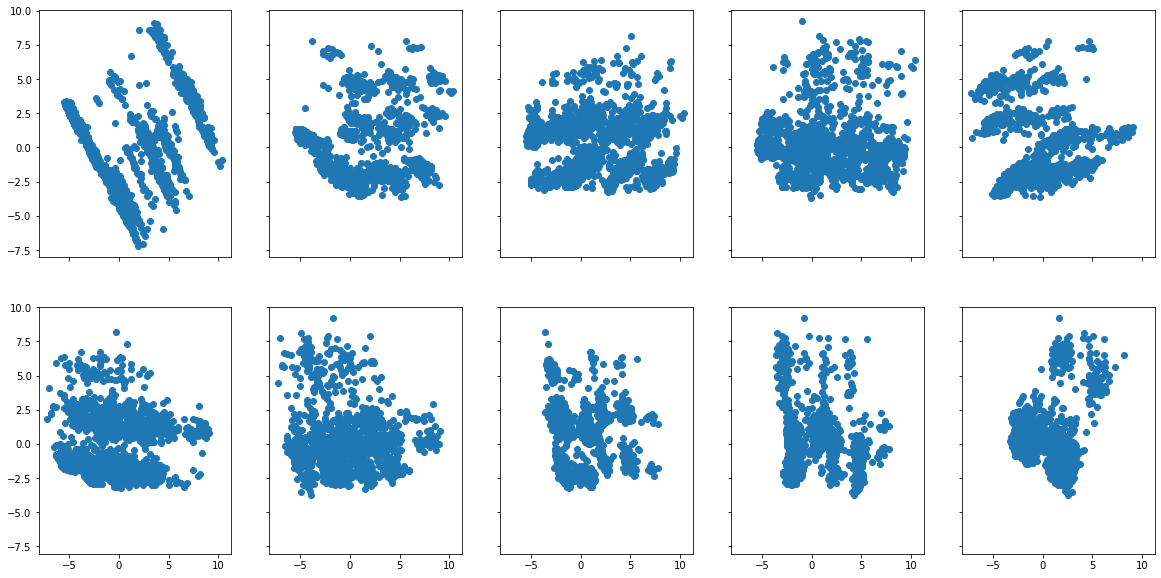

In [6]:
import matplotlib.pyplot as plt

x_pca = pca.transform(mbov_prab.to_numpy()[:,1:])
# Test the plotting
#plt.figure(figsize=(8,6))
#plt.scatter(embedding[:,3],x_pca[:,4])

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True)
axs[0,0].scatter(x_pca[:,0],x_pca[:,1])
axs[0,1].scatter(x_pca[:,0],x_pca[:,2])
axs[0,2].scatter(x_pca[:,0],x_pca[:,3])
axs[0,3].scatter(x_pca[:,0],x_pca[:,4])
axs[0,4].scatter(x_pca[:,1],x_pca[:,2])
axs[1,0].scatter(x_pca[:,1],x_pca[:,3])
axs[1,1].scatter(x_pca[:,1],x_pca[:,4])
axs[1,2].scatter(x_pca[:,2],x_pca[:,3])
axs[1,3].scatter(x_pca[:,2],x_pca[:,4])
axs[1,4].scatter(x_pca[:,3],x_pca[:,4])

plt.gcf().set_size_inches(20, 10)
plt.savefig('output.pdf')  

Join the PCA data with the country of origin & species

In [7]:
from numpy import shape
import re

import pandas as pd


row_names = full_mbov_pangenome[0,3:].columns
row_names = [s.replace('.annot','') for s in row_names]



pca.fit(mbov_prab.to_numpy()[:,3151:])
x_pca = pca.transform(mbov_prab.to_numpy()[:,3151:])
x_pca = np.append(row_names,x_pca)


In [9]:
import pandas as pd

mbov_pca = pd.DataFrame(x_pca)
mbov_meta = pl.read_csv("resources\Aim3_FilteredData.csv")

mbov_prab_meta = mbov_prab.join(mbov_meta, left_on="column", right_on="Run", how = 'left')
mbov_prab_meta.get_column("LibrarySelection")

shape: (2569,)
Series: 'LibrarySelection' [str]
[
	"RANDOM"
	"RANDOM"
	"RANDOM"
	"RANDOM"
	"RANDOM"
	"RANDOM"
	"RANDOM"
	"RANDOM"
	"RANDOM"
	"RANDOM"
	"RANDOM"
	"RANDOM"
	...
	"RANDOM"
	"RANDOM"
	"RANDOM"
	"RANDOM"
	"RANDOM"
	"size fractiona...
	"size fractiona...
	"size fractiona...
	"size fractiona...
	"size fractiona...
	"size fractiona...
	"size fractiona...
	"RANDOM"
]

(array([ 0,  0,  0, ...,  4,  4, 14], dtype=int64), array(['Cattle', 'Cervid', 'Goat', 'Porcine', 'Human', 'Feline',
       'Primate', 'Raccoon', 'Possum', 'Ferret', 'Stoat', 'Hedgehog',
       'Sheep', 'Badger', 'Capybara'], dtype=object))


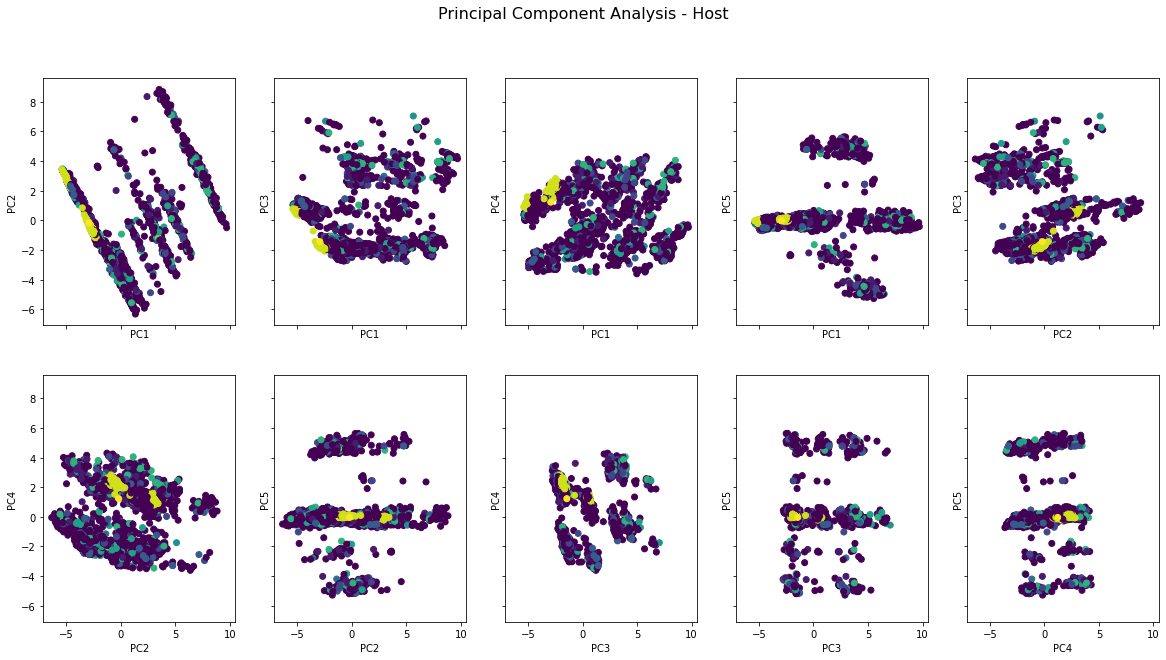

In [10]:
# Let's look specifically at the accessory genome 99% - 15%

from turtle import color
import matplotlib.pyplot as plt

from matplotlib.pyplot import legend

pca.fit(mbov_prab.to_numpy()[:,3151:4117])
x_pca = pca.transform(mbov_prab.to_numpy()[:,3151:4117])
# Test the plotting
#plt.figure(figsize=(8,6))
#plt.scatter(x_pca[:,3],x_pca[:,4])

print(pd.factorize(mbov_prab_meta.get_column("Host").to_list()))

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True)
axs[0,0].scatter(x_pca[:,0],x_pca[:,1], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[0,0].set_xlabel("PC1") 
axs[0,0].set_ylabel("PC2")
axs[0,1].scatter(x_pca[:,0],x_pca[:,2], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[0,1].set_xlabel("PC1") 
axs[0,1].set_ylabel("PC3")
axs[0,2].scatter(x_pca[:,0],x_pca[:,3], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[0,2].set_xlabel("PC1") 
axs[0,2].set_ylabel("PC4")
axs[0,3].scatter(x_pca[:,0],x_pca[:,4], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[0,3].set_xlabel("PC1") 
axs[0,3].set_ylabel("PC5")
axs[0,4].scatter(x_pca[:,1],x_pca[:,2], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[0,4].set_xlabel("PC2") 
axs[0,4].set_ylabel("PC3")
axs[1,0].scatter(x_pca[:,1],x_pca[:,3], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[1,0].set_xlabel("PC2") 
axs[1,0].set_ylabel("PC4")
axs[1,1].scatter(x_pca[:,1],x_pca[:,4], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[1,1].set_xlabel("PC2") 
axs[1,1].set_ylabel("PC5")
axs[1,2].scatter(x_pca[:,2],x_pca[:,3], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[1,2].set_xlabel("PC3") 
axs[1,2].set_ylabel("PC4")
axs[1,3].scatter(x_pca[:,2],x_pca[:,4], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[1,3].set_xlabel("PC3") 
axs[1,3].set_ylabel("PC5")
axs[1,4].scatter(x_pca[:,3],x_pca[:,4], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[1,4].set_xlabel("PC4") 
axs[1,4].set_ylabel("PC5")
fig.suptitle('Principal Component Analysis - Host', fontsize=16)

plt.gcf().set_size_inches(20, 10)
plt.savefig('output.pdf')  

We can do the association analysis now with the prab data and against host and geographic location. We will do mutual information chi.sq and possibly a scoary analysis (cattle, reservoirs, and key countries). I want to answer to see which individual genes associate with differences in host species and geographic locations. 

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#:~:text=Mutual%20information%20(MI)%20%5B1,higher%20values%20mean%20higher%20dependency.
# Chisq.test bonferroni corrected, lower p-value indicates a relationship between the the variables

# mutual information example 
from sklearn.metrics import mutual_info_score


# quick example from actual data 
mutual_info_score(mbov_prab_meta.get_column("geo_loc_name_country").to_list(),mbov_prab.to_numpy()[:,3151] )


mbov_accesory_prab = mbov_prab.to_numpy()[:,3151:]
# key = index, value = mi 
cog_mi_dict = {}

for col in range(mbov_accesory_prab.shape[1]):
    cog_mi_dict[str(col)] = mutual_info_score(mbov_accesory_prab[:,col],mbov_prab_meta.get_column("geo_loc_name_country").to_list())

print(cog_mi_dict)




{'0': 0.008203928212136676, '1': 0.0040230663061947575, '2': 0.0038490296490498064, '3': 0.004640604136192779, '4': 0.004640604136192779, '5': 0.004640604136192779, '6': 0.004640604136192779, '7': 0.004640604136192779, '8': 0.004640604136192779, '9': 0.004640604136192779, '10': 0.005478742624335847, '11': 0.007487347207888553, '12': 0.007487347207888553, '13': 0.012350085993028174, '14': 0.005904420732471976, '15': 0.004530374191532332, '16': 0.002756280431047215, '17': 0.029747977367516373, '18': 0.0035900971711983988, '19': 0.0035900971711983988, '20': 0.0035900971711983988, '21': 0.0035900971711983988, '22': 0.004530374191532332, '23': 0.005904420732471976, '24': 0.005904420732471976, '25': 0.005904420732471976, '26': 0.005904420732471976, '27': 0.005904420732471976, '28': 0.007417454175445332, '29': 0.005904420732471976, '30': 0.007779559454092442, '31': 0.005904420732471976, '32': 0.003738799704389459, '33': 0.005904420732471976, '34': 0.005904420732471976, '35': 0.002756280431047

We can look at the top 100 COGs that have an association with the data we possess, but currently the metric doesn't really have any solid basis. We can determine how significant this is by using a null distribution of random 1s and 0s to this data. This will help buttress our results in relation to values that are purely uninteresting. 

In [13]:
import matplotlib.pyplot as plt

# Sort from high to low
cog_mi_dict = dict(sorted(cog_mi_dict.items(), key=lambda x: x[1], reverse=True))
cog_mi_dict = dict(list(cog_mi_dict.items())[:100])
#print(cog_mi_dict)


df = pd.DataFrame.from_dict(
    {"COGs" : list(cog_mi_dict.keys()),
    "MI" : list(cog_mi_dict.values())
    }
)
print(df)

#plt.bar(df["COGs"],df["MI"])
#plt.title('Country of Origin')
#plt.xlabel('COGs')
#plt.ylabel('Mutual Information')
#plt.gcf().set_size_inches(20, 10)
#plt.show()

    COGs        MI
0    666  0.300425
1    667  0.300425
2    668  0.300425
3    669  0.300425
4    670  0.300425
..   ...       ...
95   795  0.113867
96  1123  0.112000
97   798  0.110439
98  1023  0.110426
99   822  0.107568

[100 rows x 2 columns]


In [ ]:
# mutual information example 
from sklearn.metrics import mutual_info_score
import random 

random.seed(10)
sample_size = 2569

mbov_accesory_prab = mbov_prab.to_numpy()[:,3151:4117]
# key = index, value = mi 
rand_mi_dict = {}

for col in range(1000):
    labels = [random.randint(0,1) for _ in range(sample_size)]
    rand_mi_dict[str(col)] = mutual_info_score(labels,mbov_prab_meta.get_column("geo_loc_name_country").to_list())


shuf_df = pd.DataFrame.from_dict(
    {"COGs" : list(rand_mi_dict.keys()),
    "MI" : list(rand_mi_dict.values())
    }
)
#print(rand_mi_dict)
plt.hist(shuf_df["MI"])
plt.title('Country of Origin - Null Distribution')
plt.xlabel('Mutual Information Score')
plt.ylabel('Frequency')
#plt.gcf().set_size_inches(20, 10)
plt.show()

: 

In [ ]:
# mutual information example 
from sklearn.metrics import mutual_info_score
import random 

random.seed(11)
sample_size = 2569

mbov_accesory_prab = mbov_prab.to_numpy()[:,3151:4117]
# key = index, value = mi 
rand_mi_dict = {}

for col in range(1000):
    labels = [random.randint(0,1) for _ in range(sample_size)]
    rand_mi_dict[str(col)] = mutual_info_score(labels,mbov_prab_meta.get_column("Host").to_list())


host_shuf_df = pd.DataFrame.from_dict(
    {"COGs" : list(rand_mi_dict.keys()),
    "MI" : list(rand_mi_dict.values())
    }
)
#print(rand_mi_dict)
plt.hist(host_shuf_df["MI"])
plt.title('Host - Null Distribution')
plt.xlabel('Mutual Information Score')
plt.ylabel('Frequency')
#plt.gcf().set_size_inches(20, 10)
plt.show()

: 

The null distribution is reminiscent of previous research I did. I can fit a gamma distribution and we can get a probabilistic value for the COGs. But from the values, we can tell that the values we got from the original value are VERY high given the max values we get from the null distributions. I think we can just take anything paste 0.01 as having an association with our metadata! 

Now that we have a way of decipering COGs with some associative ability, we need to tie the name with the values that overcome a threshold. We can filter the df for MI that is greater than 0.01 and use the index of the COG to get the COG labels. 

In [ ]:
COG_labels = list(full_mbov_pangenome[3151:4117,0])

# mutual information example 
from multiprocessing.spawn import import_main_path
from sklearn.metrics import mutual_info_score


# quick example from actual data 



mbov_accesory_prab = mbov_prab.to_numpy()[:,3151:4117]
# key = index, value = mi 
cog_mi_dict = {}

for col in range(mbov_accesory_prab.shape[1]):
    cog_mi_dict[col] = mutual_info_score(mbov_accesory_prab[:,col],mbov_prab_meta.get_column("Host").to_list())

geog_df = pd.DataFrame.from_dict(
    {"COGs" : list(cog_mi_dict.keys()),
    "MI" : list(cog_mi_dict.values())
    }
)

geog_df = geog_df[geog_df['MI'] > 0.01]
label_index = list(geog_df["COGs"])
important_COGs_geog = [COG_labels[i] for i in label_index]
print(important_COGs_geog)

: 

COGs that percolate to the top from my first look seem to confirm some hypotheses and show something quite interestig with previous research ESX genes seem to be very important here in the geographic sense. Will need to have this list for Host, create the phylogeny for population clusters, and compute lineages as well!

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=5)
embedding = reducer.fit_transform(mbov_prab.to_numpy()[:,3151:4117])

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True)
axs[0,0].scatter(embedding[:,0],embedding[:,1], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[0,0].set_xlabel("PC1") 
axs[0,0].set_ylabel("PC2")
axs[0,1].scatter(embedding[:,0],embedding[:,2], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[0,1].set_xlabel("PC1") 
axs[0,1].set_ylabel("PC3")
axs[0,2].scatter(embedding[:,0],embedding[:,3], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[0,2].set_xlabel("PC1") 
axs[0,2].set_ylabel("PC4")
axs[0,3].scatter(embedding[:,0],embedding[:,4], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[0,3].set_xlabel("PC1") 
axs[0,3].set_ylabel("PC5")
axs[0,4].scatter(embedding[:,1],embedding[:,2], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[0,4].set_xlabel("PC2") 
axs[0,4].set_ylabel("PC3")
axs[1,0].scatter(embedding[:,1],embedding[:,3], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[1,0].set_xlabel("PC2") 
axs[1,0].set_ylabel("PC4")
axs[1,1].scatter(embedding[:,1],embedding[:,4], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[1,1].set_xlabel("PC2") 
axs[1,1].set_ylabel("PC5")
axs[1,2].scatter(embedding[:,2],embedding[:,3], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[1,2].set_xlabel("PC3") 
axs[1,2].set_ylabel("PC4")
axs[1,3].scatter(embedding[:,2],embedding[:,4], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[1,3].set_xlabel("PC3") 
axs[1,3].set_ylabel("PC5")
axs[1,4].scatter(embedding[:,3],embedding[:,4], c = pd.factorize(mbov_prab_meta.get_column("Host").to_list())[0])
axs[1,4].set_xlabel("PC4") 
axs[1,4].set_ylabel("PC5")
fig.suptitle('Principal Component Analysis - Host', fontsize=16)
#plt.legend(handles=l4.legend_elements()[0], labels=list(set(mbov_prab_meta.get_column("Host").to_list())))

plt.gcf().set_size_inches(20, 10)


: 

In [ ]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True)
axs[0,0].scatter(embedding[:,0],embedding[:,1], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[0,0].set_xlabel("PC1") 
axs[0,0].set_ylabel("PC2")
axs[0,1].scatter(embedding[:,0],embedding[:,2], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[0,1].set_xlabel("PC1") 
axs[0,1].set_ylabel("PC3")
axs[0,2].scatter(embedding[:,0],embedding[:,3], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[0,2].set_xlabel("PC1") 
axs[0,2].set_ylabel("PC4")
axs[0,3].scatter(embedding[:,0],embedding[:,4], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[0,3].set_xlabel("PC1") 
axs[0,3].set_ylabel("PC5")
axs[0,4].scatter(embedding[:,1],embedding[:,2], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[0,4].set_xlabel("PC2") 
axs[0,4].set_ylabel("PC3")
axs[1,0].scatter(embedding[:,1],embedding[:,3], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[1,0].set_xlabel("PC2") 
axs[1,0].set_ylabel("PC4")
axs[1,1].scatter(embedding[:,1],embedding[:,4], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[1,1].set_xlabel("PC2") 
axs[1,1].set_ylabel("PC5")
axs[1,2].scatter(embedding[:,2],embedding[:,3], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[1,2].set_xlabel("PC3") 
axs[1,2].set_ylabel("PC4")
axs[1,3].scatter(embedding[:,2],embedding[:,4], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[1,3].set_xlabel("PC3") 
axs[1,3].set_ylabel("PC5")
axs[1,4].scatter(embedding[:,3],embedding[:,4], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[1,4].set_xlabel("PC4") 
axs[1,4].set_ylabel("PC5")
fig.suptitle('Principal Component Analysis - Geographic', fontsize=16)
#plt.legend(handles=l4.legend_elements()[0], labels=list(set(mbov_prab_meta.get_column("Host").to_list())))

plt.gcf().set_size_inches(20, 10)

: 

Let's clean up the features that correlate more with the variation that has nothing to do with our biological question 

In [ ]:
from turtle import color

from matplotlib.pyplot import legend

mbov_pca = pd.DataFrame(x_pca)
mbov_meta = pl.read_csv("resources\Aim3_FilteredData.csv")

mbov_prab_meta = mbov_prab.join(mbov_meta, left_on="column", right_on="Run", how = 'left')

pca.fit(mbov_prab.to_numpy()[:,3151:4117])
x_pca = pca.transform(mbov_prab.to_numpy()[:,3151:4117])
# Test the plotting
#plt.figure(figsize=(8,6))
#plt.scatter(x_pca[:,3],x_pca[:,4])

#cmap=cm.rainbow(np.array(list_integers)/np.mean(list_integers))

plt.scatter(x_pca[:,0],x_pca[:,1], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
plt.xlabel("PC1") 
plt.ylabel("PC2")

plt.gcf().set_size_inches(20, 10)


: 

Can we use MI to filter out the genes that associate with LibrarySelection and also Center.Name? 

In [23]:
# Testing the random number generator

rand_num = random.randint(0,1000)
print(rand_num)

random.sample(['red', 'blue'], counts=[rand_num, 1000 - rand_num], k=1000) 

149


['blue',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue

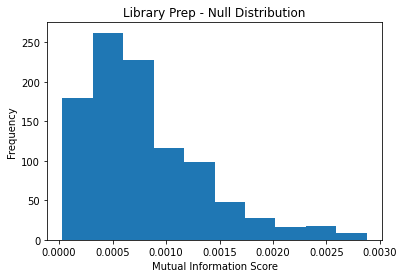

: 

In [24]:
# mutual information example 
from sklearn.metrics import mutual_info_score
import random 

random.seed(12)
sample_size = 2569

# key = index, value = mi 
rand_mi_dict = {}

for col in range(1000):
    rand_num = random.randint(0,sample_size)
    labels = random.sample([1, 0], counts=[rand_num, sample_size - rand_num], k=sample_size)
    rand_mi_dict[str(col)] = mutual_info_score(labels,mbov_prab_meta.get_column("LibrarySelection").to_list())

     
host_shuf_df = pd.DataFrame.from_dict(
    {"COGs" : list(rand_mi_dict.keys()),
    "MI" : list(rand_mi_dict.values())
    }
)
#print(rand_mi_dict)
plt.hist(host_shuf_df["MI"])
plt.title('Library Prep - Null Distribution')
plt.xlabel('Mutual Information Score')
plt.ylabel('Frequency')
#plt.gcf().set_size_inches(20, 10)
plt.show()

In [18]:
# mutual information example 
from sklearn.metrics import mutual_info_score
COG_labels = list(full_mbov_pangenome[:,0])

mbov_accesory_prab = mbov_prab.to_numpy()[:,3151:]
# key = index, value = mi 
cog_mi_dict = {}

for col in range(mbov_accesory_prab.shape[1]):
    cog_mi_dict[col] = mutual_info_score(mbov_accesory_prab[:,col],mbov_prab_meta.get_column("LibrarySelection").to_list())

batch_df = pd.DataFrame.from_dict(
    {"COGs" : list(cog_mi_dict.keys()),
    "MI" : list(cog_mi_dict.values())
    }
)

batch_df = batch_df[batch_df['MI'] < 0.01]
label_index = list(batch_df["COGs"])
important_COGs_batch = [COG_labels[i] for i in label_index]

prab_data = {}
prab_data["Name"] = list(full_mbov_pangenome.columns)[3:]
for i in label_index:
    prab_data[COG_labels[i]] = list(mbov_accesory_prab[:,i])

### create DF with the non-associated COGS

mbov_accesory_clean = pd.DataFrame.from_dict(prab_data)
mbov_accesory_clean.to_csv(".\\resources\\Aim3_PRAB.csv")

['acdA_1~~~acdA_2~~~caiA_3', 'group_2493', 'pks2_1~~~tdh_1~~~qorA_1', 'acdA_1~~~caiA_4', 'group_2458', 'lin_2~~~lin_1~~~lin', 'purF', 'group_2320', 'yfeX', 'group_2319', 'group_2318', 'purL', 'cpsY', 'group_2317', 'group_2316', 'purM', 'cpdA', 'group_2315', 'group_2314', 'group_2313', 'apeB', 'pncA', 'group_2312', 'group_2311', 'group_2310', 'group_2309', 'araQ_1~~~araQ_2', 'group_2308', 'group_2307', 'pks1_3', 'pnbA_1~~~pnbA_3', 'lacF_1~~~lacF_2', 'msiK_2', 'group_2305', 'group_2304', 'group_2302', 'group_2301', 'group_2300', 'dosT_1~~~dosT~~~dosT_2', 'group_2299', 'group_2296', 'group_2294', 'group_2293', 'acg', 'group_2290', 'group_2289', 'group_2288', 'group_2287', 'group_2286', 'group_2284', 'ctaD', 'group_2283', 'group_2282', 'ethR_1', 'tgs4', 'ylmA', 'group_2280', 'mmr', 'pknK~~~pknK_1~~~pknK_2', 'etfB', 'group_2278', 'group_2276', 'ftsX', 'serB2', 'smpB', 'group_2275', 'group_2274', 'sadH_4~~~sadH_3', 'prfB', 'group_2273', 'nrdI', 'sadH_2', 'group_2272', 'fprA', 'group_2271', '

: 

Let's filter out the COGs that have a high association with Non technical variation

In [ ]:

pca.fit(mbov_accesory_clean)
x_pca = pca.transform(mbov_accesory_clean)
# Test the plotting
#plt.figure(figsize=(8,6))
#plt.scatter(x_pca[:,3],x_pca[:,4])

#cmap=cm.rainbow(np.array(list_integers)/np.mean(list_integers))

fig, axs = plt.subplots(2, 5, sharex=True, sharey=True)
axs[0,0].scatter(x_pca[:,0],x_pca[:,1], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[0,0].set_xlabel("PC1") 
axs[0,0].set_ylabel("PC2")
axs[0,1].scatter(x_pca[:,0],x_pca[:,2], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[0,1].set_xlabel("PC1") 
axs[0,1].set_ylabel("PC3")
axs[0,2].scatter(x_pca[:,0],x_pca[:,3], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[0,2].set_xlabel("PC1") 
axs[0,2].set_ylabel("PC4")
axs[0,3].scatter(x_pca[:,0],x_pca[:,4], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[0,3].set_xlabel("PC1") 
axs[0,3].set_ylabel("PC5")
axs[0,4].scatter(x_pca[:,1],x_pca[:,2], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[0,4].set_xlabel("PC2") 
axs[0,4].set_ylabel("PC3")
axs[1,0].scatter(x_pca[:,1],x_pca[:,3], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[1,0].set_xlabel("PC2") 
axs[1,0].set_ylabel("PC4")
axs[1,1].scatter(x_pca[:,1],x_pca[:,4], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[1,1].set_xlabel("PC2") 
axs[1,1].set_ylabel("PC5")
axs[1,2].scatter(x_pca[:,2],x_pca[:,3], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[1,2].set_xlabel("PC3") 
axs[1,2].set_ylabel("PC4")
axs[1,3].scatter(x_pca[:,2],x_pca[:,4], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[1,3].set_xlabel("PC3") 
axs[1,3].set_ylabel("PC5")
axs[1,4].scatter(x_pca[:,3],x_pca[:,4], c = pd.factorize(mbov_prab_meta.get_column("geo_loc_name_country").to_list())[0])
axs[1,4].set_xlabel("PC4") 
axs[1,4].set_ylabel("PC5")
fig.suptitle('Principal Component Analysis - Host', fontsize=16)

plt.gcf().set_size_inches(20, 10)

: 

It appears the presence absence data cannot separate the data based on 2D - our Mutual Information Analysis can highlight genes that show some association with scale but the visualization seems to somewhat not be able to segragate the data. Maybe PCA + UMAP might be a better visualization but I doubt it. 

I do like how PC2 and PC3 appear, I think I can look at the break down in percentage of these clusters and this will give us some idea of what belongs to each. 

Compute the population clusters + the lineages if possible. I will need Mutual Information scores for each one before moving on to the random forest portion of the analysis

In [19]:
# moving analysis to RStudio
mbov_pca = pd.DataFrame(x_pca)

mbov_pca["Host"] = mbov_prab_meta.get_column("Host").to_list()
mbov_pca["Country"] = mbov_prab_meta.get_column("geo_loc_name_country").to_list()
mbov_pca["Sample"] = mbov_prab_meta.get_column("column").to_list()

mbov_pca.to_csv(".\\resources\\Aim3_PCA.csv")

ValueError: Length of values (2569) does not match length of index (15414)

In [22]:
pd.DataFrame(mbov_accesory_clean).to_csv(".\\resources\\Aim3_PRAB.csv")